# Binary ESN

Here I present my idea for a binary approach to the reservoir computing. I will study the dynamics of a reservoir constituted of binary *neurons* $x_i \in \{ -1, +1 \}$ for $ i = 1,2,...,N $ and binary *weights* $w_{ij} \in \{ -1, 0, +1 \}$  for $ i,j = 1,2,...,N$ (the zero value accounts for the fact that two neurons may not be linked).

The network evolve using the obvious rule

$$
x_i[n+1] = sgn ( S_i[n] )
$$

where $n$ is a (discrete) time index and:

$$
S_i[n] := \sum_i^N w_{ij}x_j[n]
$$

## Constructing the reservoir

We can think of a reservoir as a *directed weighted graph*, complitely defined by its weights matrix $w_{ij}$. In order to construct it, we use an and Erdos-Renyi procedure: each link $w_{ij}$ is created with probability $p$ or stays 0 with probability $1-p$. If it is created, its value is set to be 1 with probability $\alpha$  or -1 with probability $1 -\alpha$. Anyway, we will not use this parameters directly. Our network will instead be constructed using 3 parameters:

* N = The **number of neurons** $x_i$ in the network
* k = p/N = the **_mean_ degree** of the network ( $\in[0. ,N]$ )
* d = 1/2 - $\alpha$ = the **asymmetry** in the weights value ($\in[-0.5,0.5]$)  

which are obviously realated to $p$ and $\alpha$. This is done because these parameters are easier to understand.

The neurons initial condition $x_0$ is randomly generated according to a parameter $c$, representing the probability of a neuron to have a positive value (so that $1-c$ represent the proability of being negative).


## Theoretical aspects 

Defining $y_{ij} := w_{ij}x_j$ (time dependency is omitted) we have that its mean and variance are
$$
\hat{y} = d \hat{x}
\qquad
\hat{\sigma}^2_{y} = 1 - (d \hat{x})^2
$$
where $d$ is the asymmetry coefficient introduced above and $\hat{x}$ is the mean value of the neurons states.
So, studying $S_i$ we note that each neuron will have, on average, k incoming connection. Each one of these connection will be with one of the $y_{ij}$, so that we can study the mean $S$ considering:

$$
\hat{S} := \frac{1}{N}\sum_i^N S_i = \frac{1}{N}\sum_i^N \sum_i^N w_{ij}x_j \approx kd\hat{x}
$$

and its variance

$$
\hat{\sigma}^2_{S} = k (1 - (d \hat{x})^2)
$$

Note that this is only the variance of the states $S_i$ of a single realization of a net. Our goal would be to study the variance of the $x_i$ for a general number T of timestep and as an average on many realization of a network.

**still working on this theoretical issues**

## Network dynamics

To understand how the network evolves we carry some simulation. To analyze them, it is usefull to define:

*  **Energy** $E[n]  := \frac{1}{N}\sum_i^N x_i[n]$ (i.e. the mean value of the x)
* **Activity** $ A[n] := D(X[n],X[n-1])$ (i.e. the number of neurons that changed their state in the last step)

Here D(a,b) is the Hamming distance and $X =(x_1,x_2,...,x_N) $.


In [1]:
%pylab inline
from copy import deepcopy
from sklearn import linear_model
from numpy import linalg as LA
from joblib import Parallel, delayed
from tqdm import tqdm



class bESN:

    #Constructor
    def __init__(self, N, k, d, c = 0.5): 
        
        self.N = N # number of neurons [positive integer]
        self.k = k # asymmetry in the weight distribution [rean number, -0.5 < d < 0.5]
        self.d = d # mean degree of the network [real number, 0. < k < N]
        
        self.x = np.zeros(N) #current state of the network (each x can be +1 or -1)
        self.W = np.zeros([N,N]) #connectivity matrix (each w can be +1,0 or-1)
        
        
        self.read = np.ones(N) #controls which neuron can read the signal (1 if it can, 0 if it can not)
        
              
        
        
        self.memory = [] #list of all the past state of the network
        self.energy = [] #list of all the average of the states (REDUNDANT?)
        self.activity = [] #list of all the activity (number of neurons that changed their states) (REDUNDANT?)
        
        self.random_start(c)
        self.create_W()
    
    #creates W, the weight matrix
    def create_W(self): 
        for w in np.nditer(self.W, op_flags=['readwrite']):
            #if the random number is > p := k/N the link is created
            if np.random.rand() < ( double(self.k) / (self.N)) :
                 #if the random number is < a := 1/2 + d the weight is positive, negative otherwise (0 is the default)
                if np.random.rand() < 0.5 + self.d:
                    w[...] = 1
                else:
                    w[...] = -1
                    
    #compute the spectral radius of W               
    def spectral_radius(self):
        e_val, e_vec = LA.eig(self.W)
        
        return max(np.absolute(e_val))
    
    
    #randomly generated the starting state (c controls the amount of positive)
    def random_start(self, c = 0.5):
        for i in np.nditer(self.x, op_flags=['readwrite']):
            if np.random.rand() < c:
                i[...] = 1
            else:
                i[...] = -1
                
        self.memory.append(self.x)
        self.energy.append(mean(self.x))
        
        
    def entropy(self):
        
        return [H_b(x) for x in self.memory]
        
    
                    
            
    def _clean(self):
        start = copy(self.memory[0])
        
        self.memory = []
        self.energy = []        
    
        self.memory.append(start)
        self.energy.append(mean(start))
    

        
        
    def _switch(self,i):
        self.x[i] *= -1
                
    
    def _step(self, u = 0):
        #x_new = copy(self.x)
        
        #for i in range(self.N):
        #    h = np.dot(self.W[i],self.x) + u*self.read[i]
        #    
        #    if h:
        #        x_new[i] = np.sign(h)
         
        x_new =np.sign( self.W.dot(self.x) + u*self.read )
        x_new[x_new == 0] = self.x[x_new == 0]

            
        self.memory.append(x_new)
        self.energy.append(mean(x_new))
        self.activity.append(float (ham_dis(x_new, self.x)) / self.N)
        
        self.x = x_new
        
        
    def _old_step(self, u = 0):
        x_new = copy(self.x)
        
        for i in range(self.N):
            h = np.dot(self.W[i],self.x) + u*self.read[i]
            
            if h:
                x_new[i] = np.sign(h)
                
        self.memory.append(x_new)
        self.energy.append(mean(x_new))
        self.activity.append(float (ham_dis(x_new, self.x)) / self.N)
        
        self.x = x_new
        
        

      

    
    def evolve(self,  signal = None, nSteps = 500):
        
        if signal is None :
             for i in range(nSteps):
                self._step()
            
        else:
            
             for i in range(len(signal)):
                self._step(signal[i])
                
                
           
            
            #if i%100 == 0 :
            #    print (i, self.energy[i])
            
    def perturb(self, i):
            
        pert = bESN(self.N, self.k, self.d)
      
        
            
        pert.W = copy(self.W)
        pert.x = copy(self.memory[0])
        pert._switch(i)
        
        
        pert.memory = []
        pert.energy = []
        
        pert.memory.append(copy(pert.x))
        pert.energy.append(mean(pert.x))
    
        
        #print ("New", pert.memory)

        return pert
    
    

    
    #Learning
    
    
    def fit(self, y, T , settling ):
        
        self.ReadOut = linear_model.Ridge( alpha= 0.5)
        
      
        X_true = self.memory[settling + 1:  1 + T]
        
        self.ReadOut.fit(X_true, y)
    
        
        
    def predict(self, X):
        return self.ReadOut.predict(X)
    
    
    def learn_signal(  
                    self,
                    S,
                    delay = 0, 
                    test_length = 300, 
                    make_plot = False,
                    settling = 300
                    ):

        T = len(S) - test_length

       
        signal_train_evaluate = S[settling - delay : T - delay]

       
        signal_test_evaluate = S[T  - delay : T + test_length - delay]

    
        self.fit(signal_train_evaluate,  T = T, settling = settling)
        
     
        prev = self.predict(self.memory[T+1:])

        self.MC = MC(signal_test_evaluate, prev)


        if make_plot:
            train_prev = self.predict( self.memory[settling + 1: 1 + T] )
            
            print max(train_prev), min(train_prev)
            print 'error on the train set ', np.mean((train_prev - signal_train_evaluate)**2)
            
            
            plot(signal_test_evaluate, label = "true")
            plot(prev, label = "predicted")   
            plt.legend()
            show()

        return np.mean((prev - signal_test_evaluate)**2)
       # plot(A.energy[-100:])
       # show()

    
    
    
    def predict_signal(  
            self,
            S,
            forecasting = 0, 
            test_length = 300, 
            make_plot = False,
            settling = 300
            ):

        T = len(S) - test_length - forecasting


        signal_train_evaluate = S[settling + forecasting : T + forecasting]
        signal_test_evaluate = S[T  + forecasting : T + test_length + forecasting]

        self.fit(signal_train_evaluate, T = T, settling = settling)


        prev = self.predict(self.memory[T+1:])

        self.MC = MC(signal_test_evaluate, prev)


        if make_plot:
            train_prev = self.predict(self.memory[settling + 1: 1 + T] )


            print 'error on the train set ', np.mean((train_prev - signal_train_evaluate)**2)


            plot(signal_test_evaluate, label = "true")
            plot(prev, label = "predicted")   
            plt.legend()
            show()

        return np.mean((prev - signal_test_evaluate)**2)
        # plot(A.energy[-100:])
        # show()


Populating the interactive namespace from numpy and matplotlib


In [2]:
# %load functions_bESN.py
'''Various functions for the analysis'''


import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

from bESN import *


def ham_dis(x1, x2): #hamming distance
    return sum(el1 != el2 for el1, el2 in zip(x1, x2))

def H_b(x): #binary entropy
    p = np.mean([x == 1])
    
    q = 1 - p
    
    if p == 1 or p == 0:
        return 0
    
    return -p* np.log2(p) - q*np.log2(q)



def simulate(N, k, d, T=500, signal = None, c = 0.5):
    
    nw = bESN(N, k, d, c)
    nw.evolve(signal = signal)
    
    return nw
    
def  MC(signal, prediction):
    C = np.cov(signal, prediction)
    
    if C[0][1] == 0 or C[0][0] == 0 or C[1][1]== 0:
        return 0
    else:    
        return C[0][1]* C[0][1] / (C[0][0] * C[1][1])   

def simulate_perturbation(N, k, d, T, nPer, c = 0.5):
    nw = bESN (N, k, d, c)

    nw.evolve(nSteps = T)

    h_dist = []
    ener = []
    ent = []
    act = []



    for r in np.random.choice(N, nPer, replace = False):
        #print "r ",r
        nw_pert = nw.perturb(r)

        nw_pert.evolve(nSteps = T)

        ener.append(nw_pert.energy)
        act.append(nw_pert.activity)
        ent.append(nw_pert.entropy())
        
        dist = []
        
        for t in range(0,T+1):
            #print nw_pert.memory[t] == nw.memory[t] 
            #print ham_dis(nw_pert.memory[t], nw.memory[t])
            
            dist.append(float(ham_dis(nw_pert.memory[t], nw.memory[t])) / N)
        
        
        h_dist.append(dist)
        
    plt.figure(figsize=(14,3))
    
    pD = plt.subplot(1,4,1)
    
    Dm = np.array(h_dist).mean(axis=0)
    Dv = np.array(h_dist).std(axis=0)
    
    pD.plot(Dm, 'b' )
    pD.plot(Dm+Dv, 'r--')
    pD.plot(Dm-Dv, 'r--')
    pD.plot()
    pD.set_ylim([0,1])
    plt.title('average Hamming distance')

    pE = plt.subplot(1,4,2)
    
    Em = np.array(ener).mean(axis=0)
    Ev = np.array(ener).std(axis=0)
    
    pE.plot(Em, 'b' )
    pE.plot(Em+Ev, 'r--')
    pE.plot(Em-Ev, 'r--')
    pE.plot()
    pE.set_ylim([-1,1])
    plt.title('Energy')
    
    pA = plt.subplot(1,4,3)
   
    Am = np.array(act).mean(axis=0)
    Av = np.array(act).std(axis=0)
    
    pA.plot(Am, 'b' )
    pA.plot(Am+Av, 'r--')
    pA.plot(Am-Av, 'r--')
    pA.plot()
    pA.set_ylim([0,1])
    plt.title('Activity')
    
    pS =plt.subplot(1,4,4)
       
    Sm = np.array(ent).mean(axis=0)
    Sv = np.array(ent).std(axis=0)
    
    pS.plot(Sm, 'b' )
    pS.plot(Sm+Sv, 'r--')
    pS.plot(Sm-Sv, 'r--')
    pS.plot()
    pS.set_ylim([0,1])
    plt.title('Entropy')
    
    plt.show()


def simulate_perturbation_signal(N, k, d, signal, nPer, c = 0.5):
    nw = bESN (N, k, d, c)

    nw.evolve(signal = signal)
    h_dist = []
    ener = []
    ent = []
    act = []



    for r in np.random.choice(N, nPer, replace = False):
        #print "r ",r
        nw_pert = nw.perturb(r)

        nw_pert.evolve(signal = signal)

        ener.append(nw_pert.energy)
        act.append(nw_pert.activity)
        ent.append(nw_pert.entropy())
        
        dist = []
        
        for t in range(0, len(signal) +1):
            #print nw_pert.memory[t] == nw.memory[t] 
            #print ham_dis(nw_pert.memory[t], nw.memory[t])
            
            dist.append(float(ham_dis(nw_pert.memory[t], nw.memory[t])) / N)
        
        
        h_dist.append(dist)
        
    plt.figure(figsize=(14,3))
    
    pD = plt.subplot(1,4,1)
    
    Dm = np.array(h_dist).mean(axis=0)
    Dv = np.array(h_dist).std(axis=0)
    
    pD.plot(Dm, 'b' )
    pD.plot(Dm+Dv, 'r--')
    pD.plot(Dm-Dv, 'r--')
    pD.plot()
    pD.set_ylim([0,1])
    plt.title('average Hamming distance')

    pE = plt.subplot(1,4,2)
    
    Em = np.array(ener).mean(axis=0)
    Ev = np.array(ener).std(axis=0)
    
    pE.plot(Em, 'b' )
    pE.plot(Em+Ev, 'r--')
    pE.plot(Em-Ev, 'r--')
    pE.plot()
    pE.set_ylim([-1, 1])
    plt.title('Energy')
    
    pA = plt.subplot(1,4,3)
   
    Am = np.array(act).mean(axis=0)
    Av = np.array(act).std(axis=0)
    
    pA.plot(Am, 'b' )
    pA.plot(Am+Av, 'r--')
    pA.plot(Am-Av, 'r--')
    pA.plot()
    pA.set_ylim([0,1])
    plt.title('Activity')
    
    pS =plt.subplot(1,4,4)
       
    Sm = np.array(ent).mean(axis=0)
    Sv = np.array(ent).std(axis=0)
    
    pS.plot(Sm, 'b' )
    pS.plot(Sm + Sv, 'r--')
    pS.plot(Sm - Sv, 'r--')
    pS.plot()
    pS.set_ylim([0,1])
    plt.title('Entropy')
    
    plt.show()

def compute_MC (N, k, d, signal):
    
    A  = bESN(N, k, d)
    A.evolve(signal)
    MC = []
    
    for delay in range(0,100, 10):
        mse = A.learn_signal(signal, delay= delay, 
                         #make_plot= True, 
                         test_length= 500)
        MC.append(A.MC)
    
    return  np.sum(MC)

def compute_MC_short (N, k, d, signal):
    
    A  = bESN(N, k, d)
    A.evolve(signal)
    MC = []
    
    for delay in range(0,10):
        mse = A.learn_signal(signal, delay= delay, 
                         #make_plot= True, 
                         test_length= 500)
        MC.append(A.MC)
    
    return  np.sum(MC)

def compute_MC_instant (N, k, d, signal, delay = 0, make_plot = False):
    
    A  = bESN(N, k, d)
    A.evolve(signal)
    MC = []

    mse = A.learn_signal(signal, delay= delay, 
                     make_plot= make_plot, 
                     test_length= 500)
    MC.append(A.MC)
    if make_plot:
        ene = plot(A.energy[:], label = "E")
        act = plot(A.activity[:], label = "A")
        ENT = A.entropy()
        ent =plot(ENT[:], label = "S")
        plt.legend()
        plt.show()
    
    return  np.sum(MC)


def compute_MC_multi (N, k, d, signal):
    A  = bESN(N, k, d)
    A.evolve(signal)
    MC = []
    
    for delay in range(0,10):
        mse = A.learn_signal(signal, delay= delay, 
                         #make_plot= True, 
                         test_length= 500)
        MC.append(A.MC)
    
    return MC

def MC_multi_exp(signal):

    N = 1000    
    d_val = np.linspace(0, 0.20, 20)
    k_val = np.linspace(0., 500 , 20)
    
    memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC_multi)(N= N , k=j, d=i, signal = signal) 
                                          for i in tqdm(d_val) #righe 
                                          for j in k_val) #colonne
    memory_capacity = np.array(memory_capacity).reshape( len(d_val), len(k_val), 10)
    
    
    plt.figure(figsize=(20,10))
    
    
    for i in range(0,10):
        
        z = memory_capacity[:,:,i]
        

        plt.subplot(2, 5, i+1)
        
        plt.pcolor( k_val, d_val ,z, vmin = 0., vmax = 1. )
        plt.xlabel("k")
        plt.ylabel("d")
        plt.title("MC")
        plt.colorbar()
        
    plt.show()


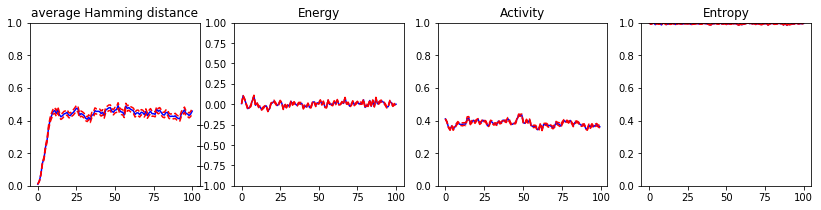

In [342]:
N = 100
k = 13.3
T = 100
d = 0


nPer = 10

simulate_perturbation(N,k,d,T,nPer, 0.6)

In [302]:
signal = []


for i in np.linspace(0, 300, 3000):
    signal.append( 2 * np.random.rand() -1 )
    #signal.append( np.sin(i) + np.sin(i*17/9))

MC_multi_exp(signal)

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 




  0%|          | 0/20 [00:00<?, ?it/s]


  5%|▌         | 1/20 [01:39<31:23, 99.15s/it]


 10%|█         | 2/20 [03:59<35:52, 119.57s/it]


 15%|█▌        | 3/20 [06:27<36:35, 129.16s/it]


 20%|██        | 4/20 [08:35<34:20, 128.78s/it]


 25%|██▌       | 5/20 [10:44<32:14, 128.95s/it]


 30%|███       | 6/20 [12:52<30:03, 128.79s/it]


 35%|███▌      | 7/20 [14:59<27:51, 128.57s/it]


 40%|████      | 8/20 [17:04<25:37, 128.11s/it]


 45%|████▌     | 9/20 [19:32<23:52, 130.24s/it]


 50%|█████     | 10/20 [22:01<22:01, 132.14s/it]


 55%|█████▌    | 11/20 [24:51<20:20, 135.56s/it]


 60%|██████    | 12/20 [27:20<18:13, 136.74s/it]


 65%|██████▌   | 13/20 [29:35<15:55, 136.54s/it]


 70%|███████   | 14/20 [32:00<13:43, 137.19s/it]


 75%|███████▌  | 15/20 [34:28<11:29, 137.92s/it]


 80%|████████  | 16/20 [37:05<09:16, 139.12s/it]


 85%|████████▌ | 17/20 [39:32<06:58, 139.55s/it]


 90%|█████████ | 18/20 [41:38<04:37, 138.80s/it]


 95%|█████████▌| 19/20 [43:45<02:18, 138.17s/it]

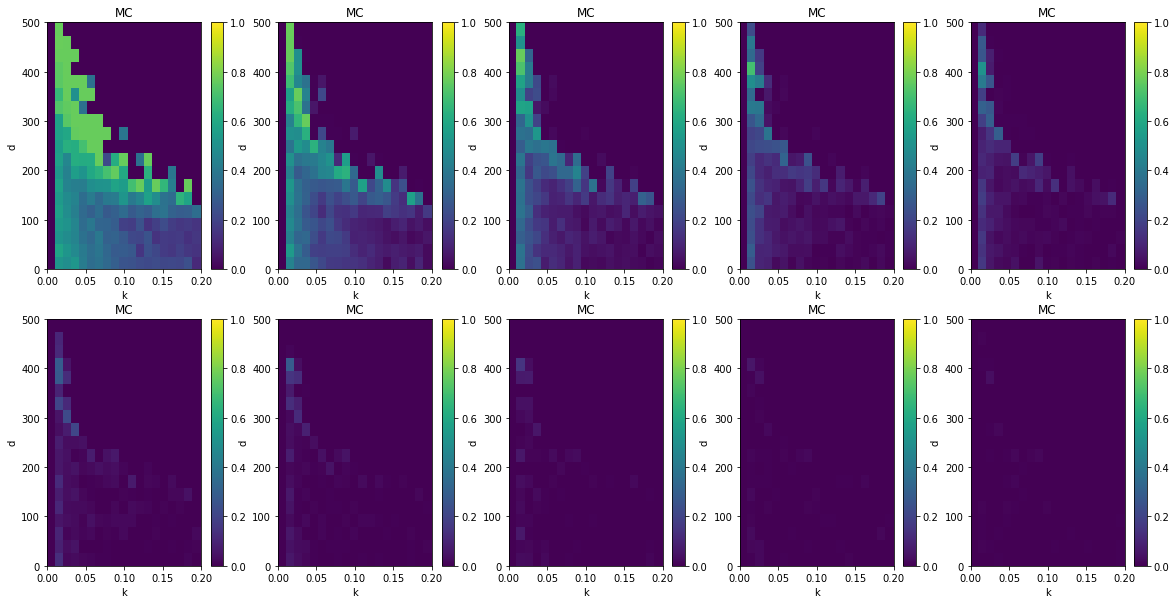

In [30]:
signal = []


for i in np.linspace(0, 300, 3000):
    signal.append( 2 * np.random.rand() )
    #signal.append( np.sin(i) + np.sin(i*17/9))

MC_multi_exp(signal)





  0%|          | 0/20 [00:00<?, ?it/s]





  5%|▌         | 1/20 [02:15<43:01, 135.89s/it]



 10%|█         | 2/20 [04:44<42:44, 142.50s/it]



 15%|█▌        | 3/20 [06:52<38:54, 137.35s/it]



 20%|██        | 4/20 [08:57<35:48, 134.27s/it]



 25%|██▌       | 5/20 [11:05<33:17, 133.16s/it]



 30%|███       | 6/20 [13:08<30:40, 131.49s/it]



 35%|███▌      | 7/20 [15:13<28:16, 130.50s/it]



 40%|████      | 8/20 [17:20<26:00, 130.05s/it]



 45%|████▌     | 9/20 [19:24<23:43, 129.39s/it]



 50%|█████     | 10/20 [21:29<21:29, 128.93s/it]



 55%|█████▌    | 11/20 [23:34<19:17, 128.62s/it]



 60%|██████    | 12/20 [25:41<17:07, 128.49s/it]



 65%|██████▌   | 13/20 [27:47<14:58, 128.29s/it]



 70%|███████   | 14/20 [29:51<12:47, 127.97s/it]



 75%|███████▌  | 15/20 [31:55<10:38, 127.67s/it]



 80%|████████  | 16/20 [34:02<08:30, 127.68s/it]



 85%|████████▌ | 17/20 [36:07<06:22, 127.52s/it]



 90%|█████████ | 18/20 [38:13<04:14, 127.40s/it]



 95%|█████████▌| 19/20 [4

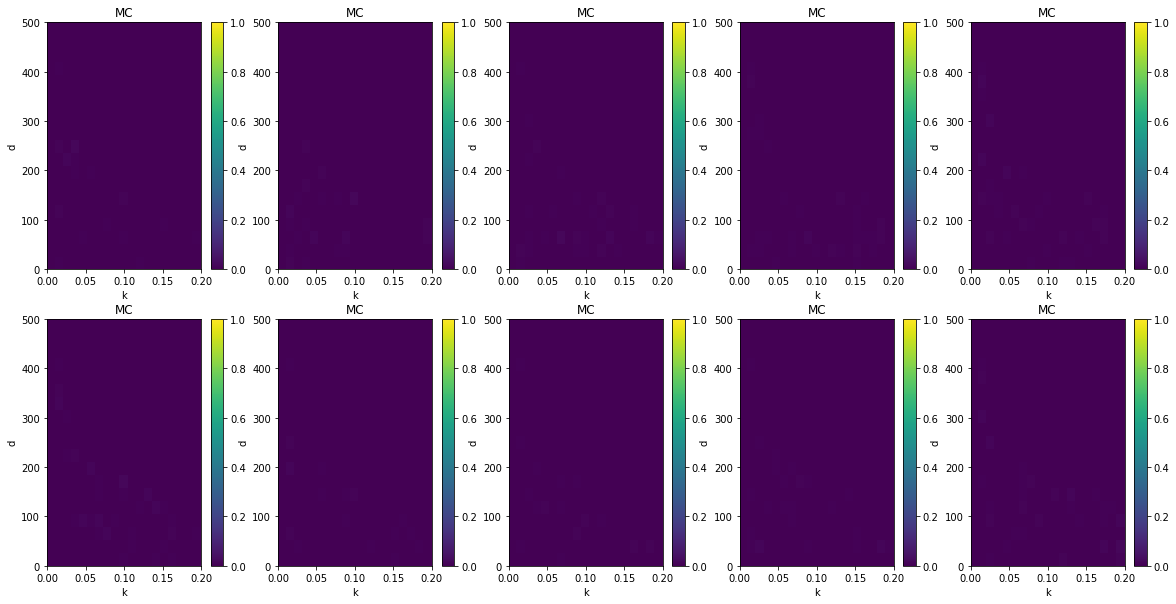

In [32]:
signal = []


for i in np.linspace(0, 300, 3000):
    signal.append( 1 * np.random.rand() )
    #signal.append( np.sin(i) + np.sin(i*17/9))

MC_multi_exp(signal)





  0%|          | 0/20 [00:00<?, ?it/s]



  5%|▌         | 1/20 [01:39<31:27, 99.33s/it]



 10%|█         | 2/20 [03:53<34:59, 116.64s/it]



 15%|█▌        | 3/20 [06:06<34:36, 122.16s/it]



 20%|██        | 4/20 [08:18<33:15, 124.72s/it]



 25%|██▌       | 5/20 [10:40<32:00, 128.01s/it]



 30%|███       | 6/20 [13:01<30:24, 130.29s/it]



 35%|███▌      | 7/20 [15:23<28:34, 131.91s/it]



 40%|████      | 8/20 [17:45<26:38, 133.19s/it]



 45%|████▌     | 9/20 [20:21<24:52, 135.71s/it]



 50%|█████     | 10/20 [22:44<22:44, 136.46s/it]



 55%|█████▌    | 11/20 [25:06<20:32, 136.92s/it]



 60%|██████    | 12/20 [27:35<18:23, 137.93s/it]



 65%|██████▌   | 13/20 [30:02<16:10, 138.62s/it]



 70%|███████   | 14/20 [32:23<13:52, 138.82s/it]



 75%|███████▌  | 15/20 [34:40<11:33, 138.71s/it]



 80%|████████  | 16/20 [37:03<09:15, 138.98s/it]



 85%|████████▌ | 17/20 [39:22<06:56, 138.97s/it]



 90%|█████████ | 18/20 [41:50<04:38, 139.50s/it]



 95%|█████████▌| 19/20 [44:2

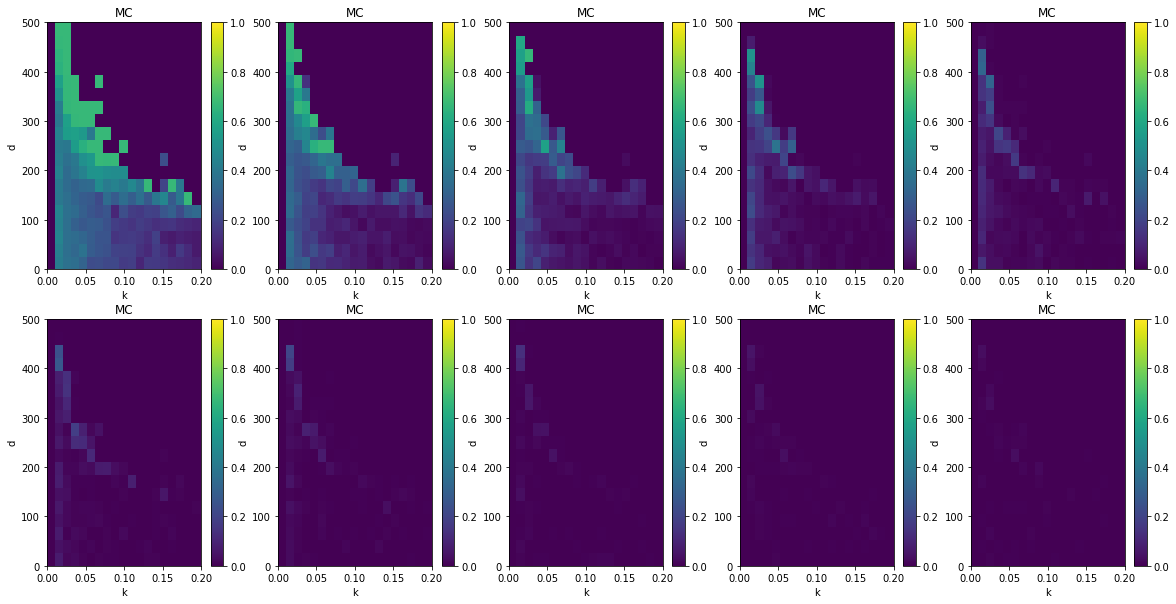

In [35]:
signal = []


for i in np.linspace(0, 300, 3000):
    signal.append( 1.5 * np.random.rand() )
    #signal.append( np.sin(i) + np.sin(i*17/9))

MC_multi_exp(signal)

100%|██████████| 20/20 [54:12<00:00, 162.63s/it]


<function matplotlib.pyplot.show>

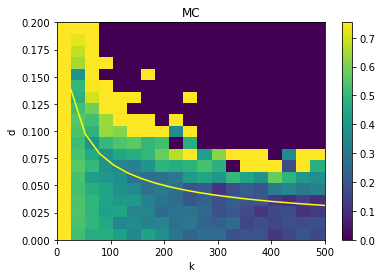

In [3]:
#MEMORY CAPACITY TEST - 0 delay - random noise

signal = []



for i in np.linspace(0, 300, 3000):
    signal.append( 2 * np.random.rand() -1 )
    #signal.append( np.sin(i) + np.sin(i*17/9))

N = 1000

d_val = np.linspace(0, 0.20, 20)
k_val = np.linspace(0., 500 , 20)
#$memory_capacity = np.array([[ compute_MC_short(N, k, d, signal) for k in k_val] for d in d_val])

memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC_instant)(N= N , k=j, d=i, signal = signal, delay = 0) 
                                      for i in tqdm(d_val) #righe 
                                      for j in k_val) #colonne

    
#compute_MC(N, 22, 0.19, signal)

y1 = d_val
x1 = k_val


z1 = np.array(memory_capacity).reshape(len(y1), len(x1))


plt.pcolor(x1,y1,z1)
plt.xlabel("k")
plt.ylabel("d")
plt.title("MC")

plt.colorbar()

plt.plot(x1[1:],1/sqrt(2*x1[1:]) , 'yellow')
plt.show

100%|██████████| 20/20 [55:12<00:00, 165.61s/it]


<function matplotlib.pyplot.show>

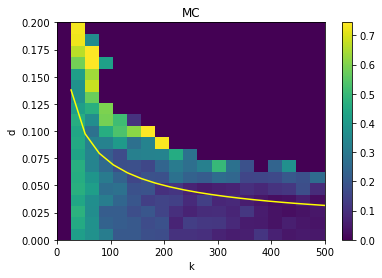

In [4]:
#MEMORY CAPACITY TEST - 1 delay - random noise

signal = []



for i in np.linspace(0, 300, 3000):
    signal.append( 2 * np.random.rand() -1 )
    #signal.append( np.sin(i) + np.sin(i*17/9))

N = 1000

d_val = np.linspace(0, 0.20, 20)
k_val = np.linspace(0., 500 , 20)
#$memory_capacity = np.array([[ compute_MC_short(N, k, d, signal) for k in k_val] for d in d_val])

memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC_instant)(N= N , k=j, d=i, signal = signal, delay = 1) 
                                      for i in tqdm(d_val) #righe 
                                      for j in k_val) #colonne

    
#compute_MC(N, 22, 0.19, signal)

y1 = d_val
x1 = k_val


z1 = np.array(memory_capacity).reshape(len(y1), len(x1))


plt.pcolor(x1,y1,z1)
plt.xlabel("k")
plt.ylabel("d")
plt.title("MC")

plt.colorbar()

plt.plot(x1[1:],1/sqrt(2*x1[1:]) , 'yellow')
plt.show

100%|██████████| 20/20 [55:58<00:00, 167.93s/it]


<function matplotlib.pyplot.show>

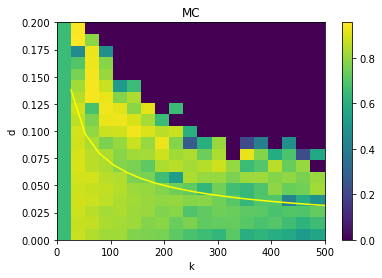

In [5]:
#MEMORY CAPACITY TEST - 0 delay - sin sin

signal = []



for i in np.linspace(0, 300, 3000):
    #signal.append( 2 * np.random.rand() -1 )
    signal.append( np.sin(i) + np.sin(i*17/9))

N = 1000

d_val = np.linspace(0, 0.20, 20)
k_val = np.linspace(0., 500 , 20)
#$memory_capacity = np.array([[ compute_MC_short(N, k, d, signal) for k in k_val] for d in d_val])

memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC_instant)(N= N , k=j, d=i, signal = signal, delay = 0) 
                                      for i in tqdm(d_val) #righe 
                                      for j in k_val) #colonne

    
#compute_MC(N, 22, 0.19, signal)

y1 = d_val
x1 = k_val


z1 = np.array(memory_capacity).reshape(len(y1), len(x1))


plt.pcolor(x1,y1,z1)
plt.xlabel("k")
plt.ylabel("d")
plt.title("MC")

plt.colorbar()

plt.plot(x1[1:],1/sqrt(2*x1[1:]) , 'yellow')
plt.show

100%|██████████| 20/20 [55:43<00:00, 167.18s/it]


<function matplotlib.pyplot.show>

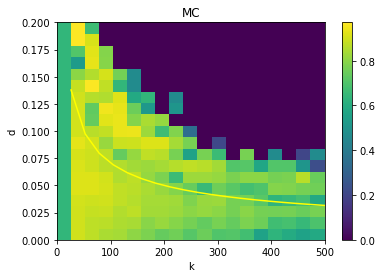

In [6]:
#MEMORY CAPACITY TEST - 1 delay - sinsin

signal = []



for i in np.linspace(0, 300, 3000):
    #signal.append( 2 * np.random.rand() -1 )
    signal.append( np.sin(i) + np.sin(i*17/9))

N = 1000

d_val = np.linspace(0, 0.20, 20)
k_val = np.linspace(0., 500 , 20)
#$memory_capacity = np.array([[ compute_MC_short(N, k, d, signal) for k in k_val] for d in d_val])

memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC_instant)(N= N , k=j, d=i, signal = signal, delay = 1) 
                                      for i in tqdm(d_val) #righe 
                                      for j in k_val) #colonne

    
#compute_MC(N, 22, 0.19, signal)

y1 = d_val
x1 = k_val


z1 = np.array(memory_capacity).reshape(len(y1), len(x1))


plt.pcolor(x1,y1,z1)
plt.xlabel("k")
plt.ylabel("d")
plt.title("MC")

plt.colorbar()

plt.plot(x1[1:],1/sqrt(2*x1[1:]) , 'yellow')
plt.show

100%|██████████| 20/20 [55:05<00:00, 165.25s/it]


<function matplotlib.pyplot.show>

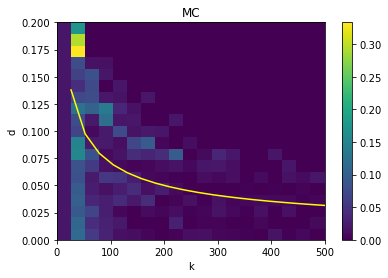

In [7]:
#MEMORY CAPACITY TEST - 5 delay - random noise

signal = []



for i in np.linspace(0, 300, 3000):
    signal.append( 2 * np.random.rand() -1 )
    #signal.append( np.sin(i) + np.sin(i*17/9))

N = 1000

d_val = np.linspace(0, 0.20, 20)
k_val = np.linspace(0., 500 , 20)
#$memory_capacity = np.array([[ compute_MC_short(N, k, d, signal) for k in k_val] for d in d_val])

memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC_instant)(N= N , k=j, d=i, signal = signal, delay = 5) 
                                      for i in tqdm(d_val) #righe 
                                      for j in k_val) #colonne

    
#compute_MC(N, 22, 0.19, signal)

y1 = d_val
x1 = k_val


z1 = np.array(memory_capacity).reshape(len(y1), len(x1))


plt.pcolor(x1,y1,z1)
plt.xlabel("k")
plt.ylabel("d")
plt.title("MC")

plt.colorbar()

plt.plot(x1[1:],1/sqrt(2*x1[1:]) , 'yellow')
plt.show

100%|██████████| 20/20 [56:13<00:00, 168.67s/it]


<function matplotlib.pyplot.show>

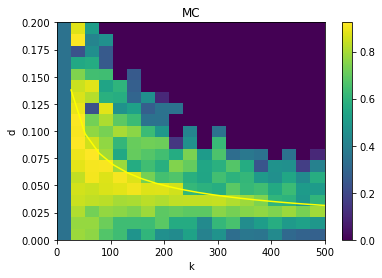

In [8]:
#MEMORY CAPACITY TEST - 5 delay - sin sin

signal = []



for i in np.linspace(0, 300, 3000):
    #signal.append( 2 * np.random.rand() -1 )
    signal.append( np.sin(i) + np.sin(i*17/9))

N = 1000

d_val = np.linspace(0, 0.20, 20)
k_val = np.linspace(0., 500 , 20)
#$memory_capacity = np.array([[ compute_MC_short(N, k, d, signal) for k in k_val] for d in d_val])

memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC_instant)(N= N , k=j, d=i, signal = signal, delay = 5) 
                                      for i in tqdm(d_val) #righe 
                                      for j in k_val) #colonne

    
#compute_MC(N, 22, 0.19, signal)

y1 = d_val
x1 = k_val


z1 = np.array(memory_capacity).reshape(len(y1), len(x1))


plt.pcolor(x1,y1,z1)
plt.xlabel("k")
plt.ylabel("d")
plt.title("MC")

plt.colorbar()

plt.plot(x1[1:],1/sqrt(2*x1[1:]) , 'yellow')
plt.show

100%|██████████| 20/20 [1:00:35<00:00, 181.78s/it]


<function matplotlib.pyplot.show>

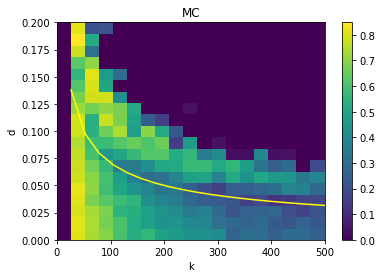

In [9]:
#MEMORY CAPACITY TEST - 1 delay - 2 random noise

signal = []



for i in np.linspace(0, 300, 3000):
    signal.append( 2*(2 * np.random.rand() -1) )
    #signal.append( np.sin(i) + np.sin(i*17/9))

N = 1000

d_val = np.linspace(0, 0.20, 20)
k_val = np.linspace(0., 500 , 20)
#$memory_capacity = np.array([[ compute_MC_short(N, k, d, signal) for k in k_val] for d in d_val])

memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC_instant)(N= N , k=j, d=i, signal = signal, delay = 1) 
                                      for i in tqdm(d_val) #righe 
                                      for j in k_val) #colonne

    
#compute_MC(N, 22, 0.19, signal)

y1 = d_val
x1 = k_val


z1 = np.array(memory_capacity).reshape(len(y1), len(x1))


plt.pcolor(x1,y1,z1)
plt.xlabel("k")
plt.ylabel("d")
plt.title("MC")

plt.colorbar()

plt.plot(x1[1:],1/sqrt(2*x1[1:]) , 'yellow')
plt.show

100%|██████████| 20/20 [1:17:33<00:00, 232.67s/it]


<function matplotlib.pyplot.show>

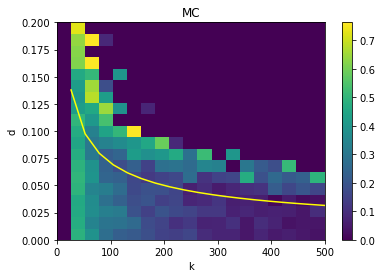

In [10]:
#MEMORY CAPACITY TEST - 1 delay - 0.5 random noise

signal = []



for i in np.linspace(0, 300, 3000):
    signal.append(0.5 * ( 2 * np.random.rand() -1) )
    #signal.append( np.sin(i) + np.sin(i*17/9))

N = 1000

d_val = np.linspace(0, 0.20, 20)
k_val = np.linspace(0., 500 , 20)
#$memory_capacity = np.array([[ compute_MC_short(N, k, d, signal) for k in k_val] for d in d_val])

memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC_instant)(N= N , k=j, d=i, signal = signal, delay = 1) 
                                      for i in tqdm(d_val) #righe 
                                      for j in k_val) #colonne

    
#compute_MC(N, 22, 0.19, signal)

y1 = d_val
x1 = k_val


z1 = np.array(memory_capacity).reshape(len(y1), len(x1))


plt.pcolor(x1,y1,z1)
plt.xlabel("k")
plt.ylabel("d")
plt.title("MC")

plt.colorbar()

plt.plot(x1[1:],1/sqrt(2*x1[1:]) , 'yellow')
plt.show

100%|██████████| 20/20 [51:46<00:00, 155.31s/it]


<function matplotlib.pyplot.show>

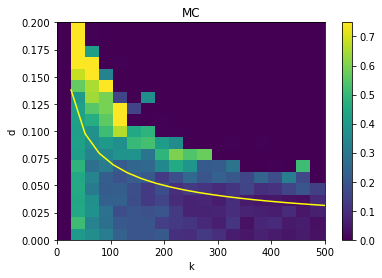

In [12]:
#MEMORY CAPACITY TEST - 1 delay -  random noise with non zero mean

signal = []


for i in np.linspace(0, 300, 3000):
    signal.append(( 2 * np.random.rand() ) )
    #signal.append( np.sin(i) + np.sin(i*17/9))

N = 1000

d_val = np.linspace(0, 0.20, 20)
k_val = np.linspace(0., 500 , 20)
#$memory_capacity = np.array([[ compute_MC_short(N, k, d, signal) for k in k_val] for d in d_val])

memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC_instant)(N= N , k=j, d=i, signal = signal, delay = 1) 
                                      for i in tqdm(d_val) #righe 
                                      for j in k_val) #colonne

    
#compute_MC(N, 22, 0.19, signal)

y1 = d_val
x1 = k_val


z1 = np.array(memory_capacity).reshape(len(y1), len(x1))


plt.pcolor(x1,y1,z1)
plt.xlabel("k")
plt.ylabel("d")
plt.title("MC")

plt.colorbar()

plt.plot(x1[1:],1/sqrt(2*x1[1:]) , 'yellow')
plt.show

100%|██████████| 20/20 [1:15:56<00:00, 227.84s/it]


<function matplotlib.pyplot.show>

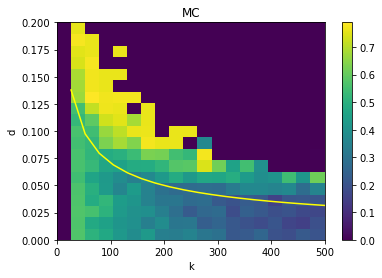

In [41]:
#MEMORY CAPACITY TEST -MC-  random noise 0 2

signal = []



for i in np.linspace(0, 300, 3000):
    signal.append( (2* np.random.rand() ) )
    #signal.append( np.sin(i) + np.sin(i*17/9))

N = 1000

d_val = np.linspace(0, 0.20, 20)
k_val = np.linspace(0., 500 , 20)
#$memory_capacity = np.array([[ compute_MC_short(N, k, d, signal) for k in k_val] for d in d_val])

memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC)(N= N , k=j, d=i, signal = signal) 
                                      for i in tqdm(d_val) #righe 
                                      for j in k_val) #colonne

    
#compute_MC(N, 22, 0.19, signal)

y1 = d_val
x1 = k_val


z1 = np.array(memory_capacity).reshape(len(y1), len(x1))


plt.pcolor(x1,y1,z1)
plt.xlabel("k")
plt.ylabel("d")
plt.title("MC")

plt.colorbar()

plt.plot(x1[1:],1/sqrt(2*x1[1:]) , 'yellow')
plt.show

100%|██████████| 20/20 [1:11:24<00:00, 214.23s/it]


<function matplotlib.pyplot.show>

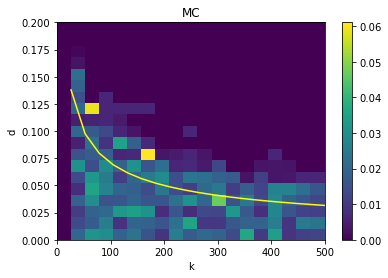

In [42]:
#MEMORY CAPACITY TEST -MC-  random noise 0 1

signal = []



for i in np.linspace(0, 300, 3000):
    signal.append( ( np.random.rand() ) )
    #signal.append( np.sin(i) + np.sin(i*17/9))

N = 1000

d_val = np.linspace(0, 0.20, 20)
k_val = np.linspace(0., 500 , 20)
#$memory_capacity = np.array([[ compute_MC_short(N, k, d, signal) for k in k_val] for d in d_val])

memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC)(N= N , k=j, d=i, signal = signal) 
                                      for i in tqdm(d_val) #righe 
                                      for j in k_val) #colonne

    
#compute_MC(N, 22, 0.19, signal)

y1 = d_val
x1 = k_val


z1 = np.array(memory_capacity).reshape(len(y1), len(x1))


plt.pcolor(x1,y1,z1)
plt.xlabel("k")
plt.ylabel("d")
plt.title("MC")

plt.colorbar()

plt.plot(x1[1:],1/sqrt(2*x1[1:]) , 'yellow')
plt.show

100%|██████████| 20/20 [49:36<00:00, 148.84s/it]


<function matplotlib.pyplot.show>

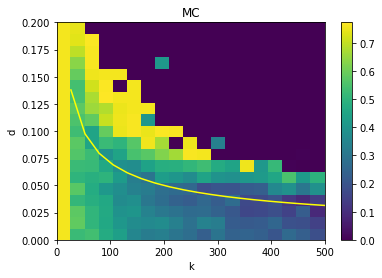

In [5]:
#MEMORY CAPACITY TEST -MC-  random noise -1 1

signal = []



for i in np.linspace(0, 300, 3000):
    signal.append( (2* np.random.rand() ) -1 )
    #signal.append( np.sin(i) + np.sin(i*17/9))

N = 1000

d_val = np.linspace(0, 0.20, 20)
k_val = np.linspace(0., 500 , 20)
#$memory_capacity = np.array([[ compute_MC_short(N, k, d, signal) for k in k_val] for d in d_val])

memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC)(N= N , k=j, d=i, signal = signal) 
                                      for i in tqdm(d_val) #righe 
                                      for j in k_val) #colonne

    
#compute_MC(N, 22, 0.19, signal)

y1 = d_val
x1 = k_val


z1 = np.array(memory_capacity).reshape(len(y1), len(x1))


plt.pcolor(x1,y1,z1)
plt.xlabel("k")
plt.ylabel("d")
plt.title("MC")

plt.colorbar()

plt.plot(x1[1:],1/sqrt(2*x1[1:]) , 'yellow')
plt.show

In [37]:
N = 1000
k = 200
d = 0.07
signal = []
for i in np.linspace(0, 200, 3000):
    #signal.append( np.sin(i) 
     #             + np.sin(i*17/9))
    
       # signal.append( (np.random.randint(-1,2)) )
        #signal.append(0)
    signal.append( (2*np.random.rand()) -1 )

    
for d in linspace(0.0,0.1,20):    
    print d,  compute_MC(N, k, d, signal
                              #,make_plot = True
                             )
   

0.0 0.339466470147
0.00526315789474 0.373810487459
0.0105263157895 0.249601961565
0.0157894736842 0.288642041369
0.0210526315789 0.323179865576
0.0263157894737 0.297981059101
0.0315789473684 0.290109062169
0.0368421052632 0.35190699781
0.0421052631579 0.329906258997
0.0473684210526 0.272994552392
0.0526315789474 0.38896140254
0.0578947368421 0.499524033913
0.0631578947368 0.511808147738
0.0684210526316 0.603753340241
0.0736842105263 0.518071660762
0.0789473684211 0.668396772309
0.0842105263158 0.722631568359
0.0894736842105 0.77545471158
0.0947368421053 0.452650223239
0.1 2.18593068622e-33


In [220]:
signal

[-0.4421428423352731,
 -0.5340520793444785,
 -0.8155234523933497,
 -0.01977392431531899,
 0.005592130489277869,
 -0.28781186887027577,
 0.4507799833176922,
 0.9875391317345033,
 -0.1793079518988585,
 0.413548584280635,
 -0.3405096918011279,
 0.7645232651524103,
 0.5564729263298165,
 0.2521719206248765,
 -0.9929648442177774,
 0.505855703157134,
 0.6866986558678803,
 -0.9868052750928835,
 -0.8482772045808595,
 -0.2599910560679637,
 0.4753508871034411,
 0.5891375519724984,
 -0.1846269032569232,
 0.8401717740777388,
 -0.945179401547745,
 -0.12644814607731458,
 -0.24209094347755356,
 -0.08213895742361066,
 0.9833518658627907,
 0.39835880975265425,
 -0.7544716636727749,
 0.5179967878400673,
 0.5435886917774977,
 0.41288450197091997,
 -0.14573172425206815,
 0.7333368409943832,
 0.8847832058490461,
 -0.15000010434688593,
 -0.46893769281434183,
 0.801713452125189,
 -0.7883364629743081,
 0.1316905113663056,
 0.7224587571118501,
 0.8706070359143419,
 0.5396387324916776,
 0.6272313093923785,
 0.84

1.38988829496 -1.37017852246
error on the train set  0.0263789390421


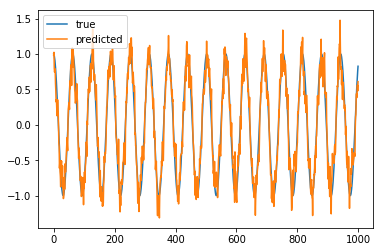

test  0.0301633316964 MC 0.939620998292
1.32770511953 -1.3344859741
error on the train set  0.0255097693648


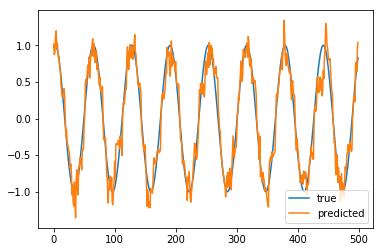

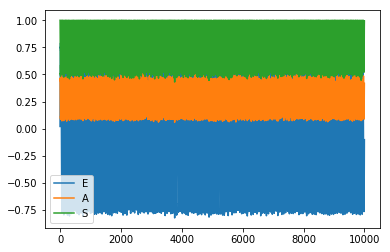

0.931398623398


In [15]:
#for d in np.linspace(-0.3, 0.3, 40):
   # MSE = []
   # for i in range(10):   
signal = []


for i in np.linspace(0, 10000, 10000):
    #signal.append( np.sin(i) 
    #              + np.sin(i*17/9)
    #             )
    
        signal.append( sin(0.1*i) )

N = 1000
k = 22
d = 0.15
A  = bESN(N, k, d)
A.evolve(signal)
mse = A.learn_signal(signal, delay= 0, make_plot= True, test_length= 1000)
print 'test ', mse, 'MC', A.MC


print compute_MC_instant (N, k, d, signal, delay = 0, make_plot = True)


In [13]:
signal

[0.0,
 0.010000833384167081,
 0.020000666493286405,
 0.029998499152356896,
 0.039993331386460829,
 0.049984163520780486,
 0.059969996280584831,
 0.069949830891176068,
 0.079922669177786357,
 0.089887513665414337,
 0.099843367678591768,
 0.10978923544107023,
 0.11972412217541782,
 0.12964703420251589,
 0.13955697904094608,
 0.1494529655062575,
 0.15933400381010412,
 0.16919910565924259,
 0.17904728435438058,
 0.18887755488886548,
 0.19868893404720409,
 0.208480440503403,
 0.21825109491911981,
 0.22799992004161609,
 0.23772594080150103,
 0.24742818441025727,
 0.2571056804575384,
 0.26675746100822845,
 0.27638256069925415,
 0.28598001683613972,
 0.29554886948929443,
 0.30508816159002455,
 0.31459693902625807,
 0.32407425073797436,
 0.33351914881232853,
 0.34293068857846071,
 0.35230792870198124,
 0.36164993127912243,
 0.37095576193054647,
 0.38022448989480168,
 0.38945518812141622,
 0.39864693336362106,
 0.40779880627069243,
 0.4169098914799042,
 0.42597927770808197,
 0.43500605784274893,

In [16]:
signal = []

for i in np.linspace(0, 1000, 10000):
    signal.append( np.sin(i) 
                  + np.sin(i*17/9)
                 )

N = 1000
k = 22
d = 0.
A  = bESN(N, k, d)
A.evolve(signal)
for delay in range(0,200, 10):
    mse = A.learn_signal(signal, delay= delay, 
                         #make_plot= True, 
                         test_length= 500)
    print delay, 'test ', mse, 'MC ', A.MC
    
    '''
0  test  0.0614391804435
5  test  0.059028721048
10  test  0.14123091576
15  test  0.268268833314
20  test  0.433317373378
25  test  0.574291991517
30  test  0.751454844383
35  test  0.917771640158
40  test  0.841867483312
45  test  0.647127656901
50  test  0.665011764905
55  test  0.709908187265
60  test  0.45229036446
65  test  0.131646034485
70  test  0.0598676767575
75  test  0.109607194192
80  test  0.158132716776
85  test  0.264438997746
90  test  0.402392600294
95  test  0.565382611338
    '''
    
    


0 test  0.079328353895 MC  0.919796766897
10 test  0.388036669413 MC  0.611926012099
20 test  0.678380616308 MC  0.332932779298
30 test  0.857850993456 MC  0.166239378728
40 test  0.993105354666 MC  0.0502550875516
50 test  0.904505847025 MC  0.1221871335
60 test  0.493179088367 MC  0.50449996631
70 test  0.161934690851 MC  0.836798396945
80 test  0.461902201065 MC  0.537889539718
90 test  0.52950472763 MC  0.477685700058
100 test  0.868979139958 MC  0.147968161548
110 test  1.05220076296 MC  0.0269069329084
120 test  0.933664076617 MC  0.0887399274485
130 test  0.339580299211 MC  0.65881182122
140 test  0.431977484704 MC  0.565449911449
150 test  0.283729043859 MC  0.71495233091
160 test  0.490721601199 MC  0.513016741106
170 test  0.947613525519 MC  0.0855533299439
180 test  1.0478108433 MC  0.0257478802039
190 test  0.826410263087 MC  0.185109612265


In [24]:
#MEMORY CAPACITY TEST

signal = []

for i in np.linspace(0, 1000, 10000):
    signal.append( np.random.rand()
                 )
N = 1000


k_val = np.linspace(100,110, 2)
d_val = np.linspace(0, 0.5, 10)
memory_capacity = np.array([[ compute_MC_instant(N, k, d, signal) for k in k_val] for d in d_val])

    
#compute_MC(N, 22, 0.19, signal)

[[  1.29675346e-04   6.19505337e-04]
 [  1.52164410e-05   9.37425271e-04]
 [  9.13995635e-34   9.13995635e-34]
 [  9.13995635e-34   9.13995635e-34]
 [  9.13995635e-34   9.13995635e-34]
 [  9.13995635e-34   9.13995635e-34]
 [  9.13995635e-34   9.13995635e-34]
 [  9.13995635e-34   9.13995635e-34]
 [  9.13995635e-34   9.13995635e-34]
 [  9.13995635e-34   9.13995635e-34]]


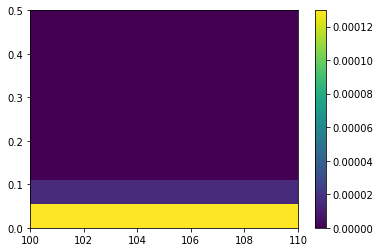

In [40]:
x = k_val[:]
y = d_val[:]
z = np.array(memory_capacity).reshape(len(d_val), len(k_val))

plt.pcolor(x,y,z)
plt.colorbar()

print z

<function matplotlib.pyplot.show>

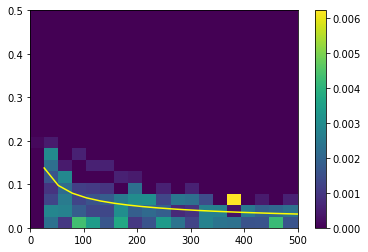

In [6]:
x = k_val[:]
y = d_val[:]
z = memory_capacity[:,:]

plt.pcolor(x,y,z)
xlabel("k")
ylabel("d")


plt.colorbar()







In [18]:
%%timeit
compute_MC(N, 3, 0, signal)

1 loop, best of 3: 20.6 s per loop


In [167]:
#MEMORY CAPACITY TEST - 0 delay

signal = []

for i in np.linspace(0, 1000, 2000):
    signal.append( 2 * np.random.rand() -1
                 )
N = 1000


k_val = np.linspace(0.1, 500, 40)
d_val = np.linspace(0, 0.5, 40)
#$memory_capacity = np.array([[ compute_MC_short(N, k, d, signal) for k in k_val] for d in d_val])

memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC_instant)(N= N , k=i, d=j, signal = signal) for i in tqdm(d_val) for j in k_val) 

    
#compute_MC(N, 22, 0.19, signal)



  0%|          | 0/40 [00:00<?, ?it/s]


  2%|▎         | 1/40 [02:28<1:36:28, 148.41s/it]

  5%|▌         | 2/40 [05:14<1:39:37, 157.31s/it]

  8%|▊         | 3/40 [08:04<1:39:39, 161.62s/it]

 10%|█         | 4/40 [11:15<1:41:20, 168.91s/it]

 12%|█▎        | 5/40 [14:05<1:38:38, 169.11s/it]

 15%|█▌        | 6/40 [16:58<1:36:10, 169.71s/it]

 18%|█▊        | 7/40 [19:50<1:33:30, 170.01s/it]

 20%|██        | 8/40 [23:02<1:32:08, 172.76s/it]

 22%|██▎       | 9/40 [27:09<1:33:33, 181.08s/it]

 25%|██▌       | 10/40 [31:21<1:34:03, 188.11s/it]

 28%|██▊       | 11/40 [35:05<1:32:31, 191.43s/it]

 30%|███       | 12/40 [38:18<1:29:23, 191.54s/it]

 32%|███▎      | 13/40 [41:34<1:26:21, 191.90s/it]

 35%|███▌      | 14/40 [44:40<1:22:57, 191.43s/it]

 38%|███▊      | 15/40 [47:32<1:19:13, 190.15s/it]

 40%|████      | 16/40 [50:12<1:15:18, 188.26s/it]

 42%|████▎     | 17/40 [52:46<1:11:23, 186.24s/it]

 45%|████▌     | 18/40 [55:22<1:07:40, 184.58s/it]

 48%|████▊     | 19/40 [57:54<

<function matplotlib.pyplot.show>

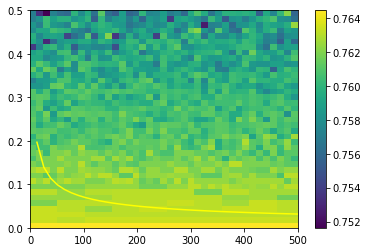

In [172]:

plt.pcolor(x,y,z)
plt.colorbar()

plt.plot(x[1:],1/sqrt(2*x[1:]) , 'yellow')
plt.show

In [ ]:
#MEMORY CAPACITY TEST - 1 delay

signal = []



for i in np.linspace(0, 1000, 1000):
    #signal.append( 2 * np.random.rand() -1 )
    signal.append( np.sin(i) + np.sin(i*17/9))

N = 1000

d_val = np.linspace(0, 0.20, 20)
k_val = np.linspace(0., 500 , 10)
#$memory_capacity = np.array([[ compute_MC_short(N, k, d, signal) for k in k_val] for d in d_val])

memory_capacity = Parallel(n_jobs=-1)(delayed(compute_MC_instant)(N= N , k=i, d=j, signal = signal, delay = 1) 
                                      for i in tqdm(d_val) #righe 
                                      for j in k_val) #colonne

    
#compute_MC(N, 22, 0.19, signal)

y1 = d_val
x1 = k_val


z1 = np.array(memory_capacity).reshape(len(y1), len(x1))


plt.pcolor(x1,y1,z1)
plt.xlabel("k")
plt.ylabel("d")
plt.title("MC")

plt.colorbar()

plt.plot(x1[1:],1/sqrt(2*x1[1:]) , 'yellow')
plt.show

In [297]:
z1 = np.array(memory_capacity).reshape(len(y1), len(x1))

print mean(z1, axis = 1)

[ 0.00868505  0.44880347  0.45417246  0.56049896  0.65544398  0.60120366
  0.74890707  0.75665503  0.75067408  0.7514977   0.75496386  0.76994443
  0.76436504  0.7859784   0.77711804  0.78334534  0.79307238  0.81242031
  0.80876443  0.82581277]


In [281]:
z1 = np.array(memory_capacity).reshape(len(y1), len(x1))

print mean(z1, axis = 1)


[ 0.00387157  0.74337629  0.74151269  0.74035243  0.73975497  0.73922012
  0.73507046  0.73264836  0.73187025  0.73081612]


0.0072573601707 0.0072573601707
error on the train set  0.446993468284


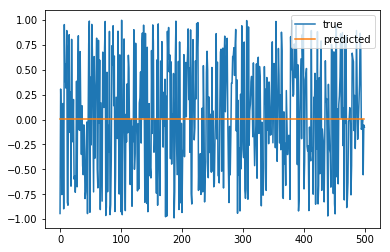

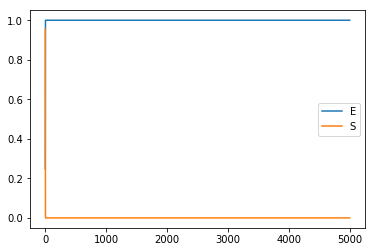

2.9409982608265115e-34

In [310]:


for i in np.linspace(0, 1000, 1000):
    signal.append( 2 * np.random.rand() -1 )
    #signal.append( np.sin(i) + np.sin(i*17/9))
    
compute_MC_instant(N= 1000 , k=200, d=0.2, signal = signal, delay = 1, make_plot= True)

In [ ]:
for d in np.linspace(-0.3, 0.3, 40):
    MSE = []
    for i in range(10):   
        signal = np.random.randint(-1, high=2 , size=4000)

        N = 1000
        k = 22.2
        T = 3000

        A = simulate(N, k, d, T, signal)



        A.fit(signal)

        #plot(signal[300:400])
        #plot( A.predict(A.memory[300:400]) )
        show()

        signal2 = np.random.randint(-1, high =2,size = 100)

        A.evolve(100, signal=signal2)
        A.predict(A.memory[1:len(signal)])


        MSE.append( np.mean((A.predict(A.memory[-100:]) - signal2)**2))
        #print (zip(A.predict(A.memory[-100:]), signal2))

        #plot(signal2)
        #plot( A.predict(A.memory[-100:]) )
        #show()
    print d, mean(MSE)

In [60]:
S = []

for i in np.linspace(0, 1000, 4100):
    S.append( np.sin(i) + np.sin(i*17/9))
    
k_val1 = np.linspace(0.1, 500, 40)
d_val1 = np.linspace(0, 0.5, 40)
Var1 = np.array([[  learn_signal(S, 1000, k, d, delay = 0) for k in k_val1] for d in d_val1  ])
    


KeyboardInterrupt: 

<function matplotlib.pyplot.show>

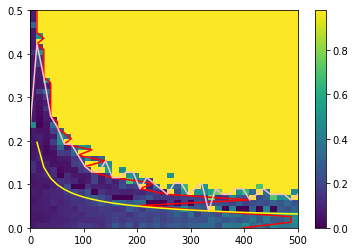

In [21]:
x = k_val1[:]
y = d_val1[:]
z = Var1[:,:]

plt.pcolor(x,y,z)
plt.colorbar()

M =  np.argmax(z,axis = 1)
plt.plot(x[M], y,'red')

M =  np.argmax(z[:][:],axis = 0)
plt.plot(x, y[M],'pink')


plt.plot(x[1:],1/sqrt(2*x[1:]) , 'yellow')
plt.show

In [63]:
S = []

for i in np.linspace(0, 1000, 4100):
    S.append( np.sin(i) 
            # + np.sin(i*17/9)
            )

    
print [learn_signal(S, 1000, 22, 0.18, delay = dd) for dd in range(10) ]







[0.011734396909895079, 0.036292783804234813, 0.12469646350091311, 0.25700468761054923, 0.44100833171010051, 0.60090315368208835, 0.62686359988898799, 1.1087391775045257, 1.3199369403478869, 1.415789046659516]


In [365]:
S = []

for i in np.linspace(0, 1000, 4100):
    S.append( np.sin(i) + np.sin(i*17/9))

    
print [learn_signal(S, 1000, 22, 0.15, delay = dd) for dd in range(10) ]

[0.08450566678050038, 0.18257427579565746, 0.48851146913638871, 1.0704769385813049, 1.4839691270940225, 2.1670675850887955, 2.4329758517311939, 2.9698547679786502, 3.2404151139696249, 2.689858801998227]


In [367]:
S = []

for i in np.linspace(0, 1000, 4100):
    S.append( np.sin(i) + np.sin(i*17/9))

    
print [learn_signal(S, 1000, 22, 0.3, delay = dd) for dd in range(10) ]

[0.18376483957883863, 0.081374663606666384, 0.9718338612459364, 0.60901911608909987, 0.83848832233712556, 1.3318133099071423, 1.9139283225381427, 2.291202498923429, 2.2289377924051217, 2.3733938510977071]


In [ ]:
S = []

for i in np.linspace(0, 1000, 4100):
    S.append( np.sin(i) + np.sin(i*17/9))

    
print [learn_signal(S, 1000, 22, 0.0, delay = dd) for dd in range(10) ]

(array([   2.,    4.,   19.,   23.,  919.,   16.,   16.,    0.,    0.,    1.]),
 array([ -1.45517430e+10,  -1.10995902e+10,  -7.64743740e+09,
         -4.19528458e+09,  -7.43131761e+08,   2.70902106e+09,
          6.16117388e+09,   9.61332670e+09,   1.30654795e+10,
          1.65176323e+10,   1.99697852e+10]),
 <a list of 10 Patch objects>)

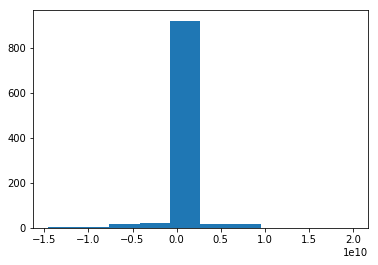

In [297]:
#A.predict(A.memory[42][None,:])
M = A.memory[-100:]

c = argmax(A.predict(M))

A.predict(M[c-3][None,:])

hist (A.ReadOut.coef_)

## Perturbations
To study how the sistem is sensible to the initial conditions, we first generate an initial condition $X_{or}$ and let the system evolve from that for $T$ timesteps. We then change one random state in $X_{or}$ and use this *pertubed* initial condition, calculating the hamming distance betwen this trajectory and the original one, for every time step. We do this for nPer different perturbation of $X_{or}$.


Each graph shows the average hamming distance of the pertubed trajectories from the original one, the energies of all the perturbed trajectory and their activities.


[array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.]), array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.]), array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.])]
original one
[array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.]), array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.]), array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.])]
('New', [array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.])])
perturbation
[array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.])]

[array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.]), array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.])]
3 2
('New', [array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.])])
perturbation
[array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.])]

[array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.]), array([ 1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.])]
3 2


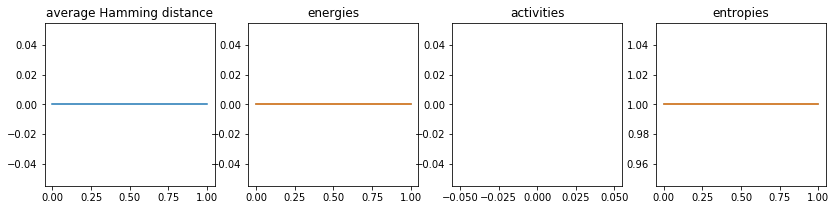

In [112]:
N = 10
k = 13.3
T = 1
d = 1

nPer = 2

simulate_perturbation(N,k,d,T,nPer, 0.6)

-0.25


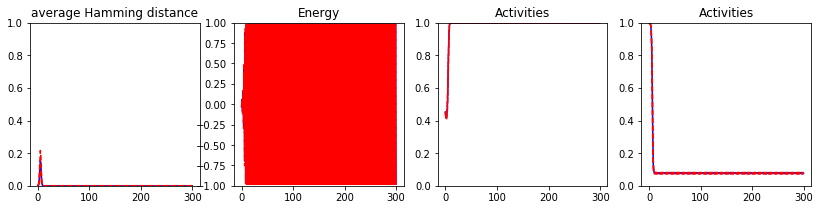

-0.237179487179


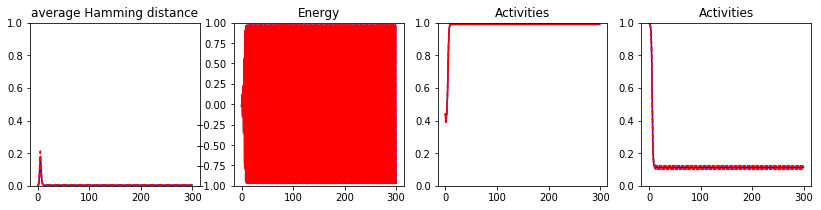

-0.224358974359


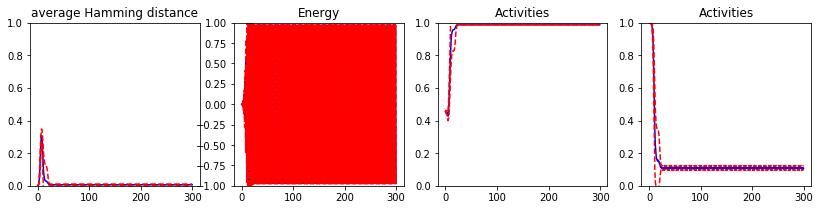

-0.211538461538


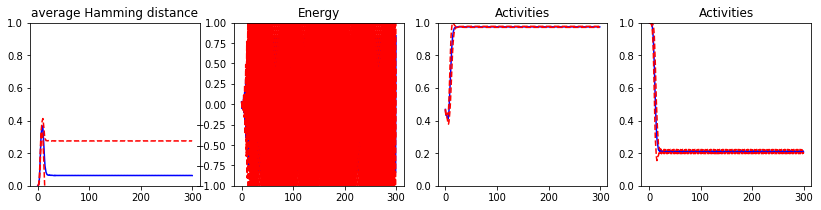

-0.198717948718


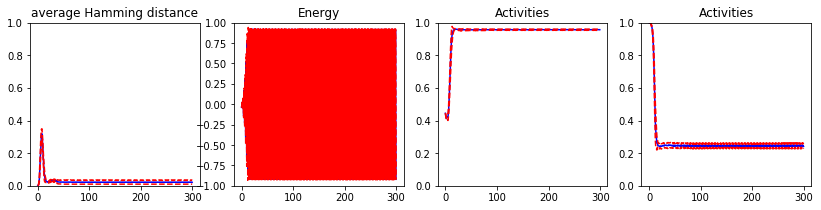

-0.185897435897


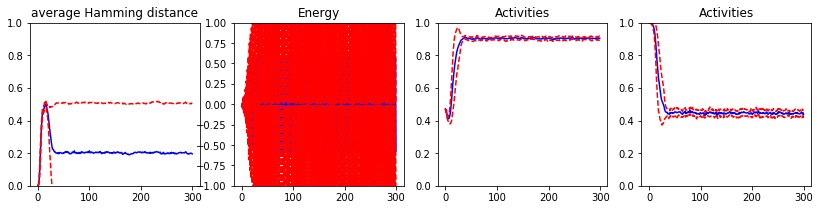

-0.173076923077


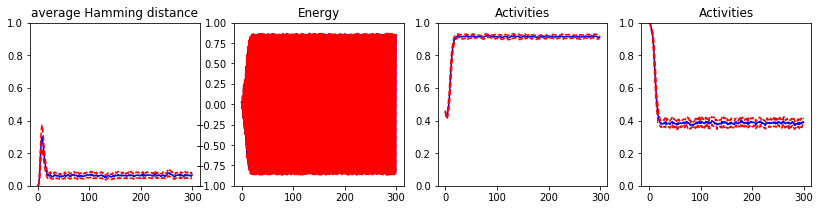

-0.160256410256


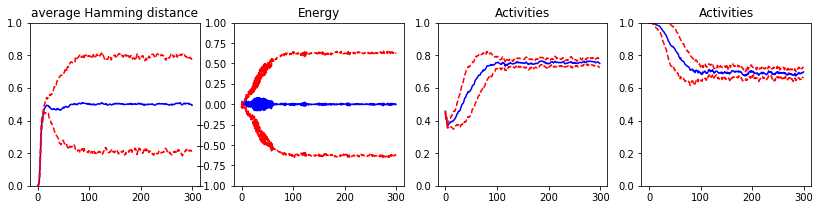

-0.147435897436


KeyboardInterrupt: 

In [339]:
#CHECKPOINT

for d in np.linspace(-0.25,0.25,40):
    
    print d
    
    N = 1000
    k = 22   
    T = 300

    nPer = 20
    simulate_perturbation(N,k,d,T,nPer, 0.6)
    


In [ ]:
k = 22
d = 0.15

print 0.5 * np.log2( k d   )

## Detecting the EoC

### Activity variance

In [40]:
k_val1 = np.linspace(0.1, 500, 40)
d_val1 = np.linspace(-0.2, 0.2, 40)
Var1 = np.array([[ np.var( simulate(1000, k, d, 300, c = 0.5).activity ) for k in k_val1] for d in d_val1  ])
        


<function matplotlib.pyplot.show>

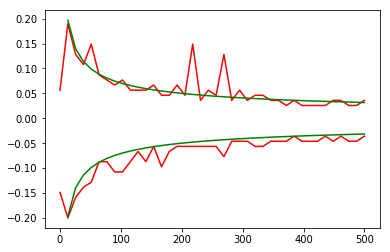

In [75]:
#Modo 1

x = k_val1[:]
y = d_val1[:]
z = Var1[:,:]


#plt.pcolor(x,y,z)
#plt.colorbar()

M =  np.argmax(z[:][:20],axis = 0)
plt.plot(x, y[M],'red')

N =  np.argmax(z[:][21:],axis = 0)
plt.plot(x, y[N+20],'red')
plt.plot(x[1:],1/sqrt(2*x[1:]) , 'green')
plt.plot(x[1:],-1/sqrt(2*x[1:]), 'green')
plt.show



<function matplotlib.pyplot.show>

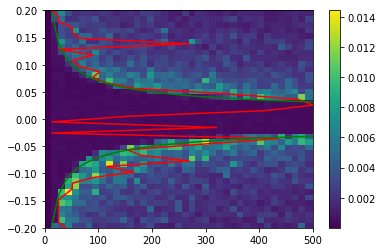

In [73]:
#Modo 2

x = k_val1[:]
y = d_val1[:]
z = Var1[:,:]


plt.pcolor(x,y,z)
plt.colorbar()

M =  np.argmax(z,axis = 1)
plt.plot(x[M], y,'red')

plt.plot(x[1:],1/sqrt(2*x[1:]) , 'green')
plt.plot(x[1:],-1/sqrt(2*x[1:]), 'green')
plt.show


In [ ]:
plt.pcolor(x,y,z)
plt.colorbar()

plt.plot(x , y(M))
plt.plot(x[1:],1/sqrt(2*x[1:]))
plt.plot(x[1:],-1/sqrt(2*x[1:]))
plt.show

/home/ouden/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


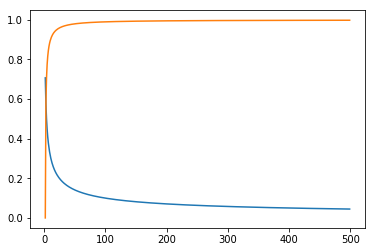

In [285]:
x = np.arange(2, 500)
plt.plot(x ,1/ sqrt(double(x)))
plt.plot(x ,1/ (sqrt(double(x)/ (double(x) -2))))

plt.show()

In [225]:
print k_val1[9], d_val1[26]

NameError: name 'k_val1' is not defined

100%|██████████| 40/40 [46:53<00:00, 70.34s/it]


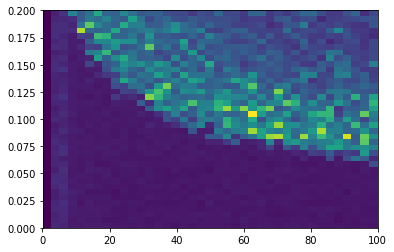

In [244]:
k_val2 = np.linspace(0.1, 100, 40)
d_val2 = np.linspace(0.0, 0.2, 40)
Var2 = np.array([[ np.var( simulate(1000, k, d, 300, c = 0.6).activity ) for k in k_val2] for d in tqdm(d_val2)  ])
        
x = k_val2[:]
y = d_val2[:]
z = Var2[:,:]
plt.pcolor(x,y,z)

100%|██████████| 40/40 [44:26<00:00, 66.66s/it]


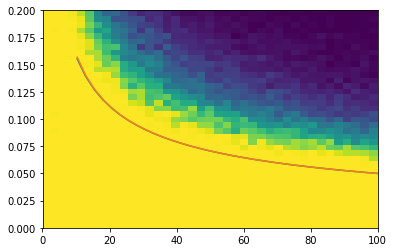

In [255]:
k_val2 = np.linspace(0.1, 100, 40)
d_val2 = np.linspace(0.0, 0.2, 40)
Var2 = np.array([[ np.mean( simulate(1000, k, d, 300, c = 0.6).entropy()[100:] ) for k in k_val2] for d in tqdm(d_val2)  ])
        
x = k_val2[:]
y = d_val2[:]
z = Var2[:,:]
plt.pcolor(x,y,z)

plt.plot(x[4:] ,0.5/sqrt(double(x[2:])))




100%|██████████| 40/40 [53:13<00:00, 79.83s/it]


ValueError: x and y must have same first dimension, but have shapes (36,) and (38,)

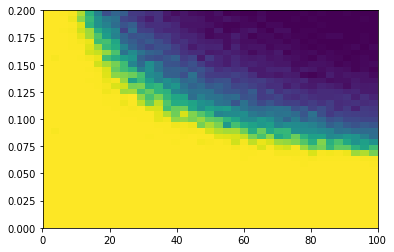

In [344]:
k_val2 = np.linspace(0.1, 100, 40)
d_val2 = np.linspace(0.0, 0.2, 40)
Var2 = np.array([[ np.mean( simulate(1000, k, d, 300, c = 0.6).entropy()[100:] ) for k in k_val2] for d in tqdm(d_val2)  ])
        
x = k_val2[:]
y = d_val2[:]
z = Var2[:,:]
plt.pcolor(x,y,z)

plt.plot(x[4:] ,0.5/sqrt(double(x[2:])))



100%|██████████| 40/40 [05:34<00:00,  8.37s/it]


ValueError: x and y must have same first dimension, but have shapes (36,) and (38,)

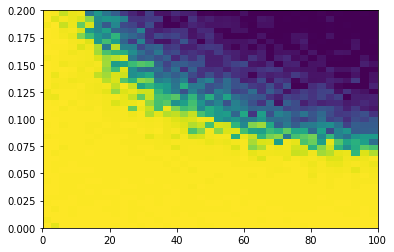

In [263]:
k_val2 = np.linspace(0.1, 100, 40)
d_val2 = np.linspace(0.0, 0.2, 40)
Var2 = np.array([[ np.mean( simulate(200, k, d, 300, c = 0.6).entropy() ) for k in k_val2] for d in tqdm(d_val2)  ])
        






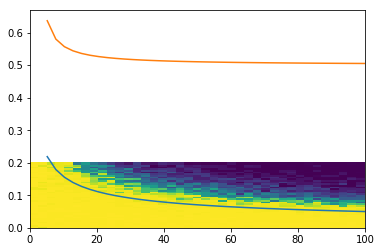

In [287]:
x = k_val2[:]
y = d_val2[:]
z = Var2[:,:]
plt.pcolor(x,y,z)

plt.plot(x[2:] ,0.5/sqrt(double(x[2:])))
plt.plot(x[2:] ,0.5/sqrt((double(x[2:]) - 2 )/ x[2:]))

### Energy variance

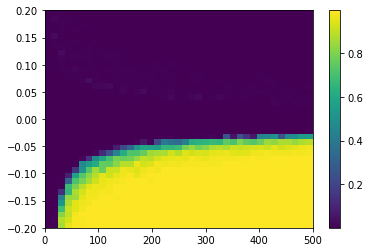

In [62]:
k_val3 = np.linspace(0.1, 500, 40)
d_val3 = np.linspace(-0.2, 0.2, 40)
Var3 = np.array([[ np.var( simulate(1000, k, d, 300, c = 0.6).energy ) for k in k_val3] for d in d_val3  ])
        
x = k_val3[:]
y = d_val3[:]
z = Var3[:,:]
plt.pcolor(x,y,z)
plt.colorbar()

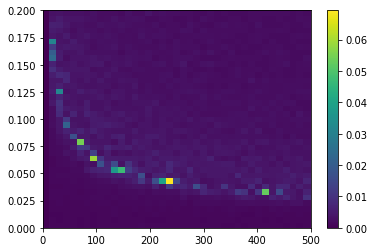

In [63]:
k_val4 = np.linspace(0.1, 500, 40)
d_val4 = np.linspace(0.0, 0.2, 40)
Var4 = np.array([[ np.var( simulate(1000, k, d, 300, c = 0.6).energy ) for k in k_val4] for d in d_val4  ])
        
x = k_val4[:]
y = d_val4[:]
z = Var4[:,:]
plt.pcolor(x,y,z)
plt.colorbar()

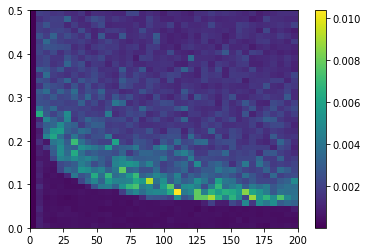

In [27]:
k_val2 = np.linspace(0.1, 200, 40)
d_val2 = np.linspace(0.0, 0.5, 40)
Var2 = np.array([[ np.var( simulate(1000, k, d, 300, c = 0.5).activity ) for k in k_val2] for d in d_val2  ])
        
x = k_val2[:]
y = d_val2[:]
z = Var2[:,:]
plt.pcolor(x,y,z)
plt.colorbar()

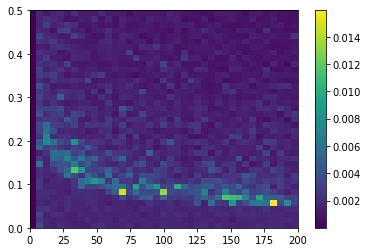

In [28]:
k_val2 = np.linspace(0.1, 200, 20)
d_val2 = np.linspace(0.0, 0.5, 20)
Var2 = np.array([[ np.mean( simulate(250, k, d, 300, c = 0.5).entropy() ) for k in k_val2] for d in d_val2  ])
        
x = k_val2[:]
y = d_val2[:]
z = Var2[:,:]
plt.pcolor(x,y,z)
plt.colorbar()

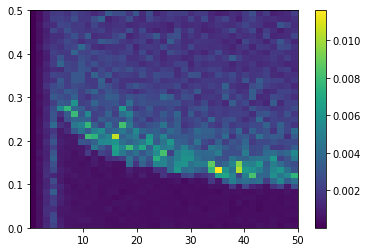

In [47]:
k_val2 = np.linspace(0.1, 50, 40)
d_val2 = np.linspace(0.0, 0.5, 40)
Var2 = np.array([[ np.var( simulate(1000, k, d, 300, c = 0.5).activity ) for k in k_val2] for d in d_val2  ])

x = k_val2[:]
y = d_val2[:]
z = Var2[:,:]
plt.pcolor(x,y,z)
plt.colorbar()

11.6153846154


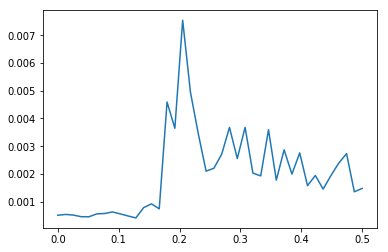

In [48]:
n = 9
plot(y,z[:,n])
print x[n]

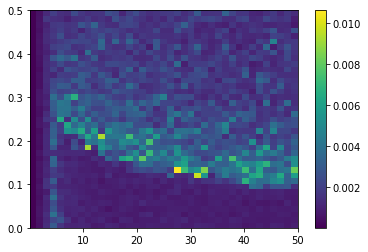

In [49]:
k_val2 = np.linspace(0.1, 50, 40)
d_val2 = np.linspace(0.0, 0.5, 40)
Var2 = np.array([[ np.var( simulate(500, k, d, 300, c = 0.5).activity ) for k in k_val2] for d in d_val2  ])

x = k_val2[:]
y = d_val2[:]
z = Var2[:,:]
plt.pcolor(x,y,z)
plt.colorbar()

In [ ]:
k_val2 = np.linspace(0.1, 50, 40)
d_val2 = np.linspace(0.0, 0.5, 40)
Var2 = np.array([[ np.var( simulate(2000, k, d, 300, c = 0.5).activity ) for k in k_val2] for d in d_val2  ])

x = k_val2[:]
y = d_val2[:]
z = Var2[:,:]
plt.pcolor(x,y,z)
plt.colorbar()

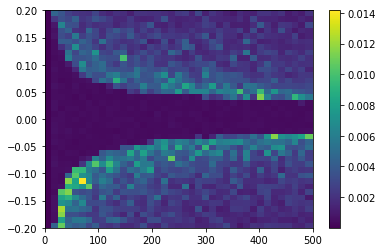

In [19]:
k_val1 = np.linspace(0.1, 500, 40)
d_val1 = np.linspace(-0.2, 0.2, 40)
Var1 = np.array([[ np.var( simulate(1000, k, d, 300, c = 0.5).activity ) for k in k_val1] for d in d_val1  ])
        
x = k_val1[:]
y = d_val1[:]
z = Var1[:,:]
plt.pcolor(x,y,z)
plt.colorbar()

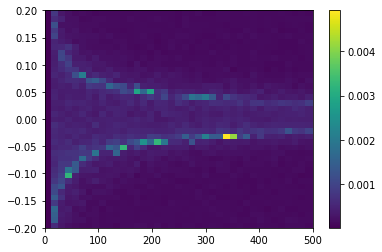

In [20]:
k_val1 = np.linspace(0.1, 500, 40)
d_val1 = np.linspace(-0.2, 0.2, 40)
Var1 = np.array([[ np.var( simulate(1000, k, d, 300, c = 0.8).activity ) for k in k_val1] for d in d_val1  ])
        
x = k_val1[:]
y = d_val1[:]
z = Var1[:,:]
plt.pcolor(x,y,z)
plt.colorbar()

<function matplotlib.pyplot.show>

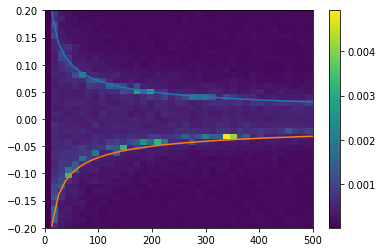

In [32]:
x = k_val1[:]
y = d_val1[:]
z = Var1[:,:]
plt.pcolor(x,y,z)
plt.colorbar()

plt.plot(x[1:],1/sqrt(2*x[1:]))
plt.plot(x[1:],-1/sqrt(2*x[1:]))
plt.show


In [2]:
a = np.array([1,1,0,1,0])
b = np.array([1,2,3,4,5])
a[a == 0 ] = b[a==0]
a

NameError: name 'np' is not defined

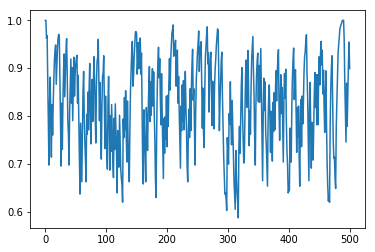

In [63]:
k = 10
d = 0.14

T =500

NN = bESN(1000, k, d)

U= np.random.randint(-1, high=1, size = T )

NN.evolve( U)


plot (NN.entropy())
show()

In [445]:
k = 200
d = 0.4
T = 500

NN = bESN(1000, k, d)


NN.spectral_radius()

159.61129800395889

<function matplotlib.pyplot.show>

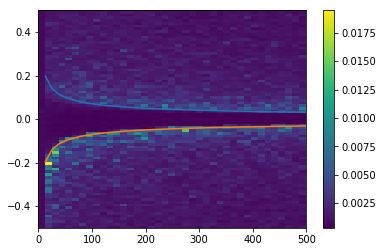

In [48]:

# Segnale {0,1}


k_val1 = np.linspace(0.1, 500, 40)
d_val1 = np.linspace(-0.5, 0.5, 80)
Var1 = np.array([[ np.var( simulate(1000, 
                                    k, 
                                    d, 
                                    300, 
                                    signal = np.random.randint(2, size = 300),
                                    c = 0.6).activity ) 
                  for k in k_val1] for d in d_val1  ])
        
x = k_val1[:]
y = d_val1[:]
z = Var1[:,:]
plt.pcolor(x,y,z)
plt.colorbar()

plt.plot(x[1:],1/sqrt(2*x[1:]))
plt.plot(x[1:],-1/sqrt(2*x[1:]))
plt.show

<function matplotlib.pyplot.show>

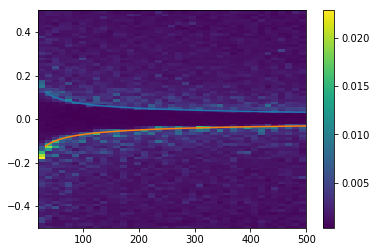

In [63]:
# Segnale {-1,0,1}

k_val1 = np.linspace(20, 500, 40)
d_val1 = np.linspace(-0.5, 0.5, 80)
Var1 = np.array([[ np.var( simulate(1000, 
                                    k, 
                                    d, 
                                    300, 
                                    signal = np.random.randint(3, size = 300) - 1,
                                    c = 0.6).activity ) 
                  for k in k_val1] for d in d_val1  ])
        
x = k_val1[:]
y = d_val1[:]
z = Var1[:,:]
plt.pcolor(x,y,z)
plt.colorbar()

plt.plot(x[1:],1/sqrt(2*x[1:]))
plt.plot(x[1:],-1/sqrt(2*x[1:]))
plt.show

<function matplotlib.pyplot.show>

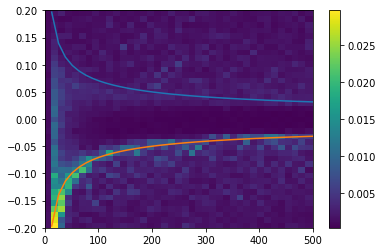

In [50]:
# Segnale {0,1,2,3,4,5}

k_val1 = np.linspace(0.1, 500, 40)
d_val1 = np.linspace(-0.5, 0.5, 80)
Var1 = np.array([[ np.var( simulate(1000, 
                                    k, 
                                    d, 
                                    300, 
                                    signal = np.random.randint(6, size = 300),
                                    c = 0.6).activity ) 
                  for k in k_val1] for d in d_val1  ])
        
x = k_val1[:]
y = d_val1[:]
z = Var1[:,:]
plt.pcolor(x,y,z)
plt.colorbar()

plt.plot(x[1:],1/sqrt(2*x[1:]))
plt.plot(x[1:],-1/sqrt(2*x[1:]))
plt.show

0.00246600376667


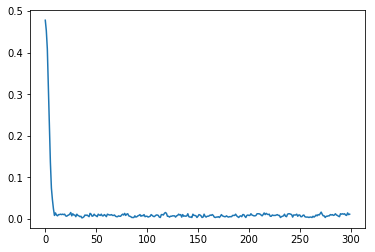

In [46]:
k = 100
d = 0.1

a = simulate(1000, k,   d, 300, signal = np.random.randint(3, size = 300) - 1,c = 0.6).activity
plt.plot(a)
print np.var(a)

0.000398829722222
0.0027408256


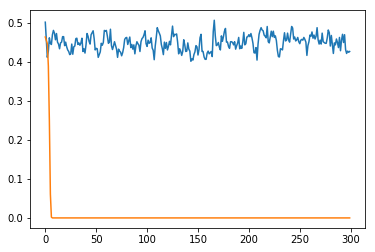

In [51]:
k = 100
d = 0.0

a = simulate( 1000, k,   d, 300, c = 0.5).activity
plt.plot(a)
print np.var(a)

k = 100
d = -0.15

a = simulate( 1000, k,   d, 300, c = 0.5).activity
plt.plot(a)
print np.var(a)



0.00122277062222
0.00197521826667
0.00264132182222
0.00190743826667
0.00123607226667
0.00137010462222
0.00190392545556
0.00179963528889
0.00194779665556
0.00221734528889
0.00271545798889
0.00200140678889
0.00242612555556
0.00306566056667
0.00249960412222
0.00229595576667
0.00743826462222
0.0053478651
0.000527337955556
0.000381649722222
0.000531692566667
0.000583154622222
0.00607369515556
0.0055676075
0.00250819528889
0.00207555062222
0.00333139132222
0.0015515075
0.00177859222222
0.00167543523333
0.00195407506667
0.00162619462222
0.00118287648889
0.00253194248889
0.00153427928889
0.00136186412222
0.00173959728889
0.00157895826667
0.00153769222222
0.00106086598889


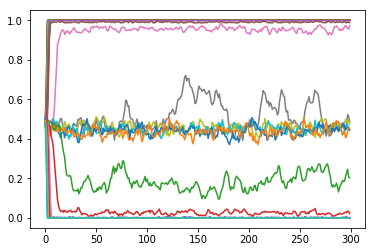

In [64]:
r1 = []
for d in np.linspace(-0.5, 0.5, 40):

    k = 100

    a = simulate(1000, k,   d, 300, signal = np.random.randint(3, size = 300) - 1, c = 0.6).activity
    r1.append( var(a) )
    plt.plot(a)
    print  np.var(a)
    


0
10
20
30
40
50
60
70
80
90


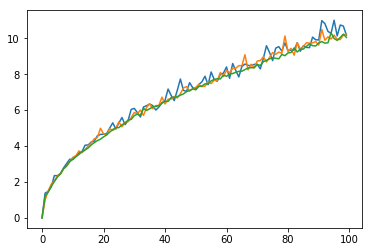

In [10]:
k_1 = []
k_2 = []
k_3 = []

MAX = 100
for i in range(0, MAX):
    if (i%10 == 0): 
        print i

    P1 = bESN(MAX, i, 0)
    k_1.append(P1.spectral_radius())
    
    P2 = bESN(2*MAX, i, 0)
    k_2.append(P2.spectral_radius())

    P3 = bESN(10*MAX, i, 0)
    k_3.append(P3.spectral_radius())
    

plot(k_1)
plot(k_2)
plot(k_3)

In [5]:

k_val1 = np.linspace(0.1, 500, 40)
d_val1 = np.linspace(-0.2, 0.2, 40)
Var1 = parallel(n_jobs=-1)(delayed(simulate)(N= N , k=j, d=i, signal = signal).entropy() 
                                          for i in tqdm(d_val) #righe ]
                                          for j in k_val) #colonne
        
x = k_val1[:]
y = d_val1[:]
z = Var1[:,:]
plt.pcolor(x,y,z)
plt.colorbar()

arallel(n_jobs=-1)(delayed(simulate)(N= N , k=j, d=i, signal = signal).entropy() 
                                          for i in tqdm(d_val) #righe ]
                                          for j in k_val) #colonne


NameError: name 'parallel' is not defined